In [1]:
from pathlib import Path
from dateutil.relativedelta import relativedelta
import datetime as dt

import numpy as np
import pandas as pd
from prophet import Prophet


ROOT_DIR = Path("../../")
DATA_DIR = ROOT_DIR / "data"
TRAIN_DATA_PATH = DATA_DIR / "02_intermediate" / "train_power.csv"
FUTURE_DATA_PATH = DATA_DIR / "02_intermediate" / "cv_power.csv"

FOURIER_ORDER = 2

/Users/james/Library/Caches/pypoetry/virtualenvs/kedro-ml-nola2EqA-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_from_file(path):
    return pd.read_csv(path, parse_dates=["datetime"])


def preprocess(df):
    return df.rename(columns={"datetime": "ds", "power_kw": "y"})

def calculate_errors_from_year_of_data(y, y_hat):
    y = np.array(y)
    y_hat = np.array(y_hat)
    
    errors = []
    error_periods_days = (1, 7, 30, 365)
    for period in error_periods_days:
        errors.append(rmse(y[:period*24], y_hat[:period*24]))
    return errors
    
    

def rmse(y, y_hat):
    return np.sqrt(np.mean((y-y_hat)**2))



In [3]:
# Round 1
train_data = (
    load_from_file(TRAIN_DATA_PATH)
    .pipe(preprocess)
)

model = Prophet()
model.add_seasonality(name="hourly", period=1/24, fourier_order=FOURIER_ORDER)

model.fit(train_data)

22:00:22 - cmdstanpy - INFO - Chain [1] start processing
22:01:15 - cmdstanpy - INFO - Chain [1] done processing


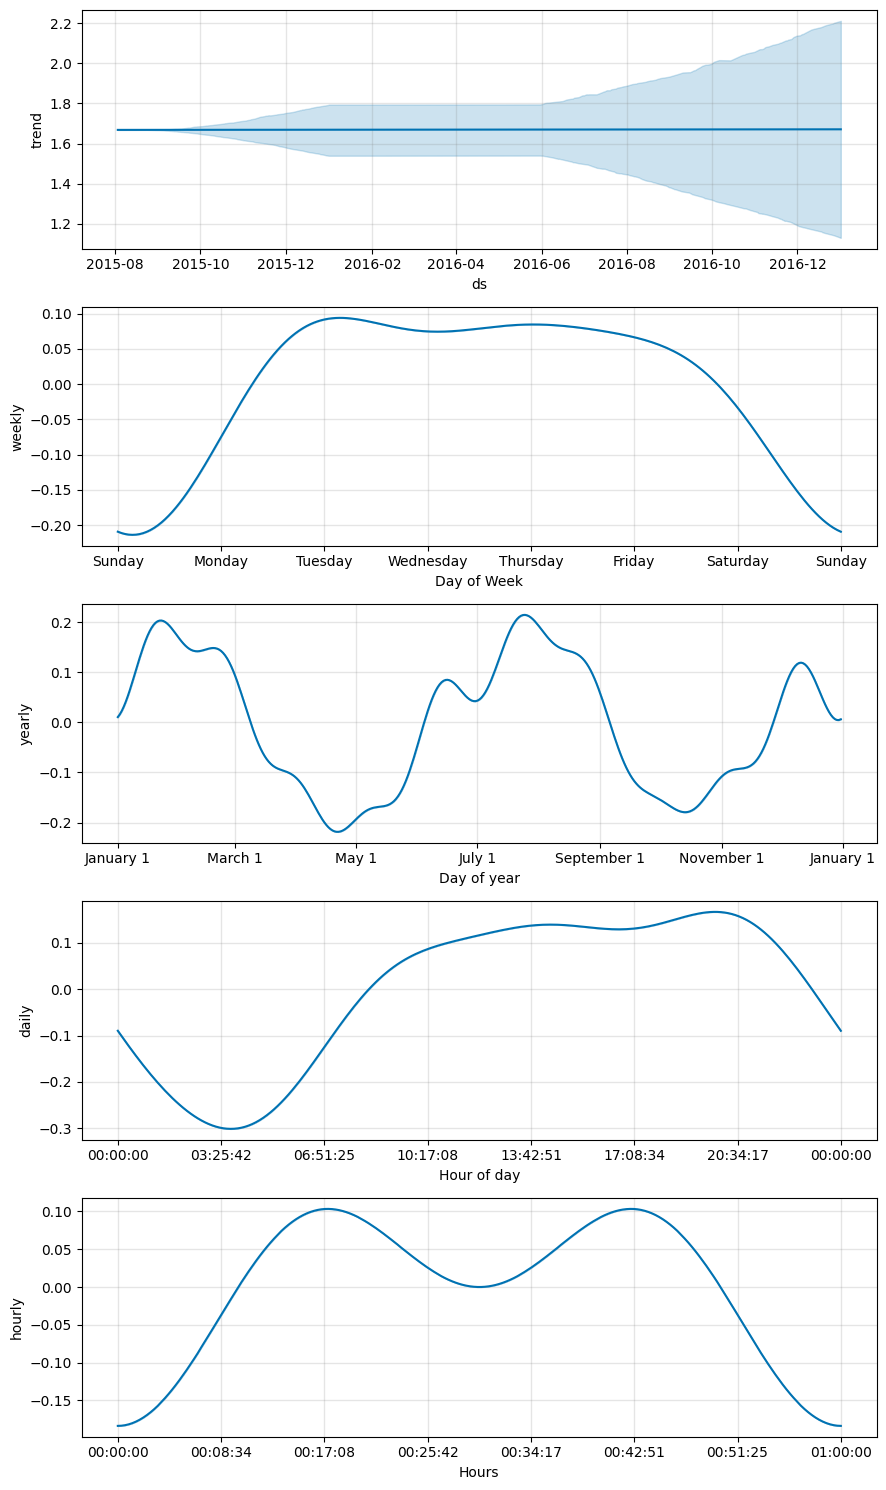

In [4]:
future_data = (
    load_from_file(FUTURE_DATA_PATH)
    .pipe(preprocess)
)

# The data is two years long so we can just half it
half_of_future_data = int(len(future_data)/2)
first_year_future = future_data[:half_of_future_data]
second_year_future = future_data[half_of_future_data:]

first_year_forecast = model.predict(first_year_future)

fig = model.plot_components(first_year_forecast)

In [5]:
first_errors = calculate_errors_from_year_of_data(first_year_future.y, first_year_forecast.yhat)
first_errors

[0.2991859996922662,
 0.3720642476829535,
 0.30193528804177777,
 0.39117234162785713]

In [6]:
# Round 2
train_data = (
    load_from_file(TRAIN_DATA_PATH)
    .pipe(preprocess)
)

model = Prophet()
model.add_seasonality(name="hourly", period=1/24, fourier_order=FOURIER_ORDER)

model.fit(pd.concat([train_data, first_year_future]))

22:01:25 - cmdstanpy - INFO - Chain [1] start processing
22:02:13 - cmdstanpy - INFO - Chain [1] done processing


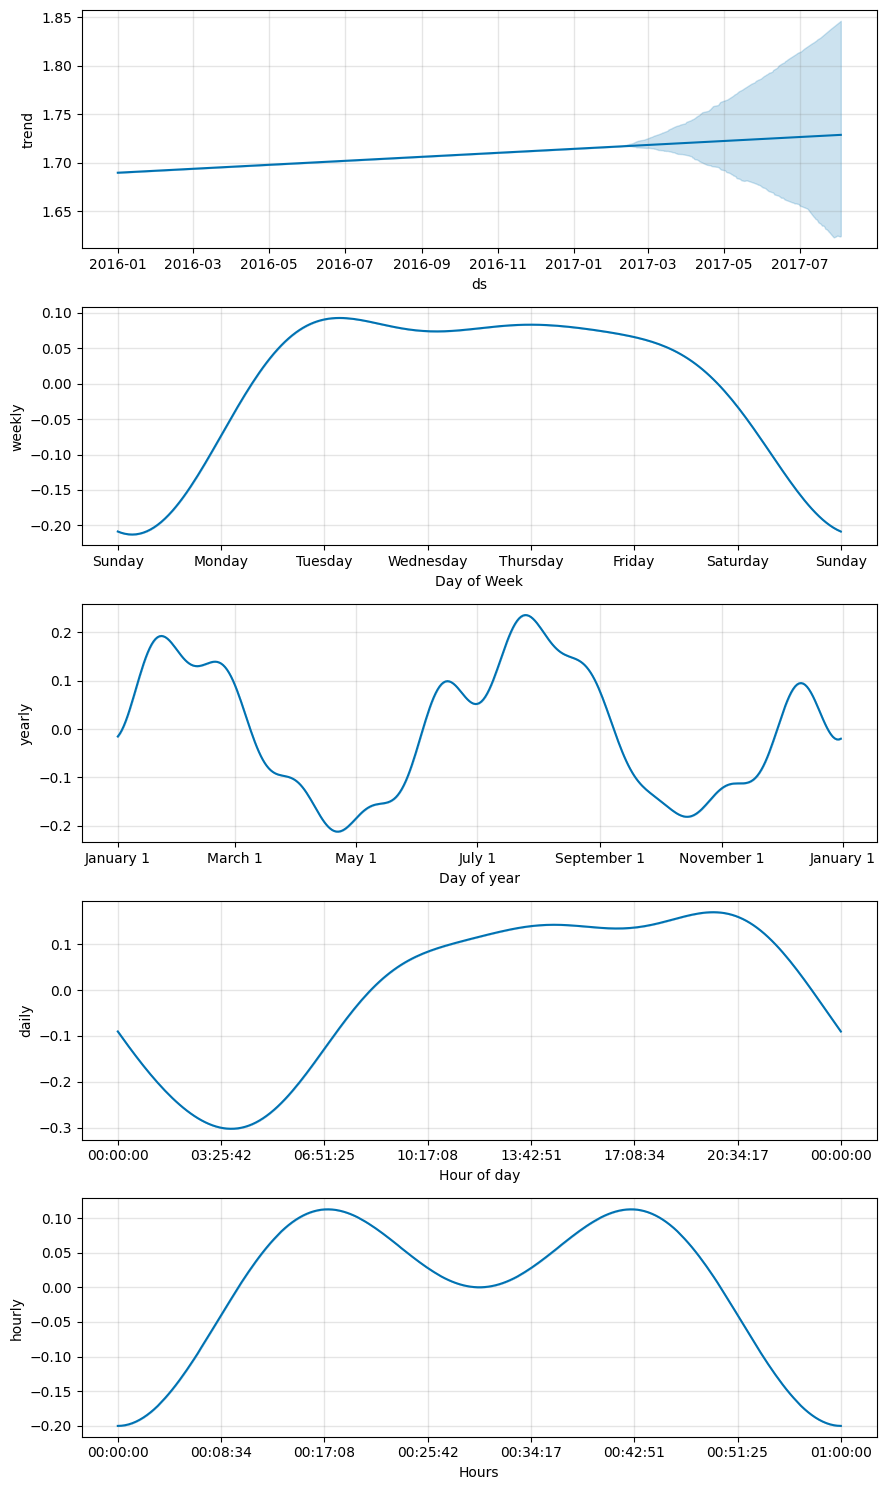

In [7]:
second_year_forecast = model.predict(second_year_future)

fig = model.plot_components(second_year_forecast)

In [8]:
second_errors = calculate_errors_from_year_of_data(second_year_future.y, second_year_forecast.yhat)
second_errors

[0.5173182941739483,
 0.38143517821597095,
 0.44570046329028257,
 0.32366921360750384]

In [9]:
overall_errors = (np.array(first_errors) + np.array(second_errors))/2
overall_errors

array([0.40825215, 0.37674971, 0.37381788, 0.35742078])

In [10]:
year_error = overall_errors[3]
year_error

0.3574207776176805